## __Vector Quantized Variational AutoEncoder (VQ-VAE)__ Modelling

Source: [Neural Discrete Representation Learning](https://proceedings.neurips.cc/paper/2017/hash/7a98af17e63a0ac09ce2e96d03992fbc-Abstract.html)

### __VQ-VAE Architecture__

VQ_VAE uses __discrete latent variable__ instead of continuous to pass into decoder of the network.

At first, we define a latent embedding space $e\in \mathbb{R}^{k\times D}$ where $K$ is the size of discrete latent space (or ``codebook``)and $D$ is the dimension of each latent embedding vector.

- Model takes the input $x$ and encoder output $z_{e}(x)$. Here $z_{e}(x)$ is a continuous representation of input $x$.

- Next step is __Vector Quantization__ process, where the encoder output of $z_{e}(x)$ is replaced by nearest embedding vector $e_{k}$ from the codebook as given below:
$$ z_{q}(x) = e_{k} \quad \text{where} \quad
k = \arg\min_j \| z_e(x) - e_j \|_2 $$

Here, $e_{j}$ is the j-th row embeding vector $e_{j} \in \mathbb{R}^D$ and $\| z_e(x) - e_j \|_2$ is the Euclidean distance between encoder's output and j-th row embedding vector

- This makes posterior $q(z |x)$ a one-hot categorical distribution as follows:
$$
q(z=k \mid x) =
\begin{cases}
1 & \text{if } k = \arg\min_j \| z_e(x) - e_j \|_2 \\
0 & \text{otherwise}
\end{cases}$$

and these embedding $z_{q}(x)$ are then passed into decoder to reconstruct $x$.

### __Training Part__

During the forward pass, the nearest embedding $z_{q}(x)$ is passed to the decoder, and during the backwards pass the gradient $∇_{z}L$ is passed unaltered to the encoder. Since the encoder's output and decoder's input share the same $D$ dimensional space, the gradients contain useful information for encoder how to lower its reconstruction loss. Below given image is borrowed from original paper for representing this process:

![VQ-VAE illustration](img/vq_vae.png)


**Loss function**

Our loss function has three components to it

- Reconstruction Loss - It optimizes the decoder and encoder, and where due to straight-through estimator gradient flow from decoder to encoder in backward pass.
- Vector Quantization or CodeBook Loss - It uses L2 squared distance error to move the embedding vector $e_{i}$ towards the encoder output $z_{e}(x)$. It is the second term in loss function given below.
- Commitment Loss - It makes sure the encoder commits to an embedding and its output does not grow arbitrarily large.

Thus, the total loss function is given as:

$$L = \log p(x|z_{q}(x)) + \lVert \text{sg} [z_{e}(x)] - e \rVert_{2}^2 + \beta \lVert z_{e}(x) - \text{sg}[e]\rVert_2^2$$

Key thing: Decoder optimizes the first loss term - reconstruction loss, encoder optimizes first and last loss term, and embeddings are optimized by codebook loss, the second term only.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torch.optim import Adam
from torchinfo import summary

In [2]:
#Setting up dataset, transform, and dataloaders
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

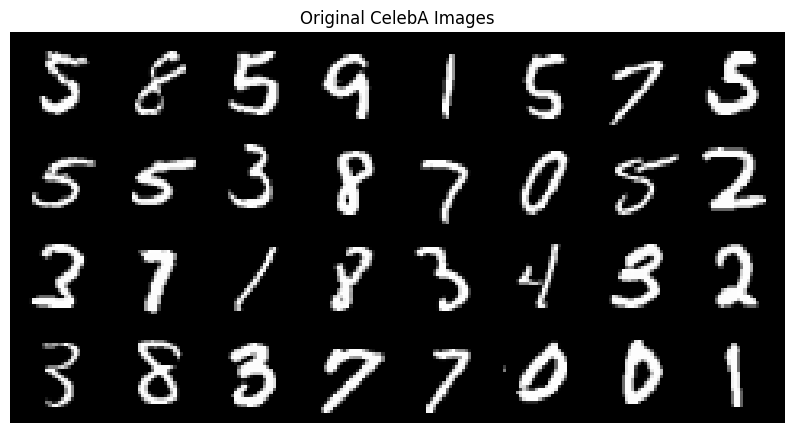

In [3]:
def show_images(images, title=None, nrow=8):
    grid = make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0))) # changing order of grid to (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Getting new batch of training celeba data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Plotting images
show_images(images[:32], "Original CelebA Images")

### __VQ-VAE Modelling__

In [4]:
class VectorQuantizer(nn.Module):

    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super().__init__()
        self.num_embeddings = num_embeddings            #K - size of embedding space or codebook
        self.embedding_dim = embedding_dim              #D - Dimension of each embedding
        self.commitment_cost = commitment_cost          #Beta from loss function eq

        self.embedding = nn.Embedding(num_embeddings, embedding_dim) #initializing embedding table
        nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        
    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).contiguous()      # (B, C, H, W) -> (B*H*W, C)
        flat_x = flat_x.view(-1, self.embedding_dim)     # (B*H*W, D) flattening for VQ

        #L2 Square distance calculation
        distances = (
            torch.sum(flat_x**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(flat_x, self.embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1) #taking argmin from eq 1
        quantized = self.embedding(encoding_indices)      #z_{q}(x) = e_{k}

        #reshaping z_{q}(x) back to match the dimension of  z_{e}(x) 
        quantized = quantized.view(x.shape[0], x.shape[2], x.shape[3], -1).permute(0, 3, 1, 2)

        # Straight-Through Estimator
        quantized = x + (quantized - x).detach()

        #Loss function second and last term
        codebook_loss = F.mse_loss(quantized.detach(), x)                 #middle term for loss function
        commitment_loss = self.commitment_cost * F.mse_loss(x.detach(), quantized)               #last term of loss function 

        # Returning quantized, codebook_loss, commitment_loss, and encoding_indices
        return quantized, codebook_loss, commitment_loss, encoding_indices.view(x.shape[0], -1)

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32, commitment_cost=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, embedding_dim, 1)
        )

        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, codebook_loss, commitment_loss, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, codebook_loss, commitment_loss, encoding_indices

    def decode_from_indices(self, indices):
      #Converting indices to embeddings (shape: B, L, D)
      quantized = self.vq.embedding(indices)
      #Reshapes it back to spatial grid (assuming L = H × W)
      H = W = int(indices.shape[1]**0.5)
      quantized = quantized.view(indices.shape[0], H, W, -1) # (B, H, W, D)
      quantized = quantized.permute(0, 3, 1, 2)              # (B, D, H, W)
      return self.decoder(quantized)

In [6]:
num_epochs = 20
learning_rate = 25e-4

#defining model, optimizer, and learning rate
model = VQVAE(num_embeddings=64, embedding_dim=32, commitment_cost=0.25)
optimizer = Adam(model.parameters(), lr=learning_rate)

In [7]:
print(summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 64, 14, 14]           1,088
│    └─LeakyReLU: 2-2                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 128, 7, 7]            131,200
│    └─LeakyReLU: 2-4                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-5                       [1, 32, 7, 7]             4,128
├─VectorQuantizer: 1-2                   [1, 32, 7, 7]             --
│    └─Embedding: 2-6                    [49, 32]                  2,048
├─Sequential: 1-3                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 14, 14]          65,664
│    └─LeakyReLU: 2-8                    [1, 128, 14, 14]          --
│    └─ConvTranspose2d: 2-9              [1, 64, 28, 28]           

In [8]:
#training loop
import time
from tqdm import tqdm
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_codebook_loss = 0
  accumulated_commitment_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(tqdm(train_loader)):

    optimizer.zero_grad()
    recon_batch, codebook_loss, commitment_loss, _ = model(data)

    recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='mean')
    total_loss = recon_loss + codebook_loss + commitment_loss

    total_loss.backward()
    training_loss += total_loss.item()
    accumulated_recon_loss += recon_loss.item()
    accumulated_codebook_loss += codebook_loss.item()
    accumulated_commitment_loss += commitment_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.4f} '
          f'Reconstruction Loss: {accumulated_recon_loss / len(train_loader.dataset):.4f} '
          f'Codebook Loss: {accumulated_codebook_loss / len(train_loader.dataset):.4f} '
          f'Commitment Loss: {accumulated_commitment_loss / len(train_loader.dataset):.4f}')

for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

100%|██████████| 938/938 [02:01<00:00,  7.73it/s]


Epoch: 1 Total Loss: 0.0057 Reconstruction Loss: 0.0016 Codebook Loss: 0.0033 Commitment Loss: 0.0008


100%|██████████| 938/938 [02:23<00:00,  6.55it/s]


Epoch: 2 Total Loss: 0.0045 Reconstruction Loss: 0.0013 Codebook Loss: 0.0026 Commitment Loss: 0.0006


100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


Epoch: 3 Total Loss: 0.0040 Reconstruction Loss: 0.0012 Codebook Loss: 0.0022 Commitment Loss: 0.0006


100%|██████████| 938/938 [02:27<00:00,  6.36it/s]


Epoch: 4 Total Loss: 0.0040 Reconstruction Loss: 0.0012 Codebook Loss: 0.0022 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:40<00:00,  5.83it/s]


Epoch: 5 Total Loss: 0.0039 Reconstruction Loss: 0.0012 Codebook Loss: 0.0021 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:28<00:00,  6.33it/s]


Epoch: 6 Total Loss: 0.0037 Reconstruction Loss: 0.0012 Codebook Loss: 0.0020 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:28<00:00,  6.31it/s]


Epoch: 7 Total Loss: 0.0036 Reconstruction Loss: 0.0012 Codebook Loss: 0.0019 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:26<00:00,  6.39it/s]


Epoch: 8 Total Loss: 0.0035 Reconstruction Loss: 0.0012 Codebook Loss: 0.0019 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:28<00:00,  6.32it/s]


Epoch: 9 Total Loss: 0.0035 Reconstruction Loss: 0.0012 Codebook Loss: 0.0018 Commitment Loss: 0.0005


100%|██████████| 938/938 [02:28<00:00,  6.31it/s]


Epoch: 10 Total Loss: 0.0034 Reconstruction Loss: 0.0012 Codebook Loss: 0.0018 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:29<00:00,  6.26it/s]


Epoch: 11 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:35<00:00,  6.03it/s]


Epoch: 12 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:41<00:00,  5.80it/s]


Epoch: 13 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:32<00:00,  6.14it/s]


Epoch: 14 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:38<00:00,  5.91it/s]


Epoch: 15 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:31<00:00,  6.20it/s]


Epoch: 16 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:38<00:00,  5.93it/s]


Epoch: 17 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:34<00:00,  6.08it/s]


Epoch: 18 Total Loss: 0.0033 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


Epoch: 19 Total Loss: 0.0032 Reconstruction Loss: 0.0012 Codebook Loss: 0.0017 Commitment Loss: 0.0004


100%|██████████| 938/938 [02:34<00:00,  6.09it/s]

Epoch: 20 Total Loss: 0.0032 Reconstruction Loss: 0.0012 Codebook Loss: 0.0016 Commitment Loss: 0.0004
Total Training Time: 50 min 14.42 s


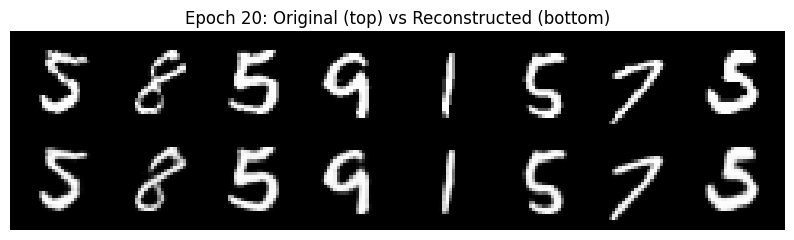

In [9]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():

  sample = images[:8]
  recon, _, _,_ = model(sample)
  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Epoch {epoch}: Original (top) vs Reconstructed (bottom)')

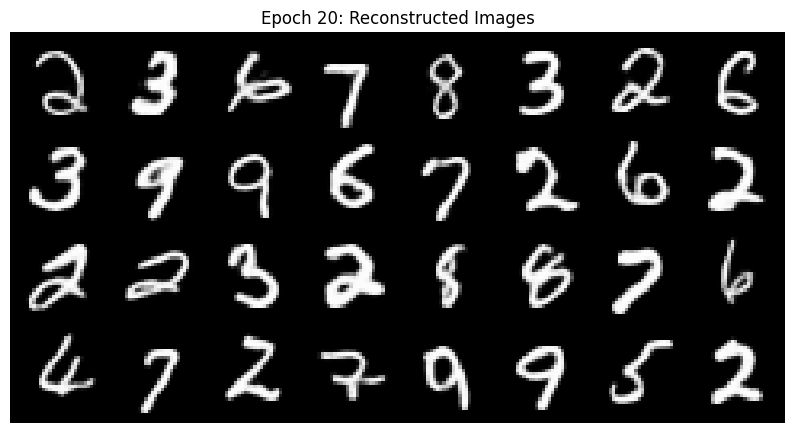

In [10]:
# displaying only reconstructed images
model.eval()
with torch.no_grad():
  dataiter = iter(train_loader)
  images, _ = next(dataiter)

  sample = images[:32] 
  recon, _, _,_ = model(sample)

  show_images(recon, f'Epoch {epoch}: Reconstructed Images')